# **Optimizing the JobTeaser Placement Funnel**

## **1. Introduction:**
### **Context:**
**JobTeaser** is a platform that connects students and companies by managing career services for over 750 universities globally. It provides a **matching tool** where companies can shortlist students for job opportunities. Optimizing the job placement funnel is critical to enhancing student employment rates and improving the platform's efficiency

### **Project Goal:**
The goal of this project is to analyze and optimize the JobTeaser job placement funnel by identifying bottlenecks in the current process and suggesting improvements to increase student engagement and job matches.

### **Data Overview:**
This analysis uses three key datasets:
#### **Opt-in Table (optin):**
 Contains data about students opting in or out of JobTeaser services.

- **user_id:** ID of the student.
- **receive_time:** Date/time of opt-in/out.
- **cause:** Reason (manual or automatic).
- **active:** TRUE if opted in, FALSE if opted out.
- **school_id:** ID of the school.
- **current_sign_in_at:** Last login time.
- **resume_uploaded:** Whether the resume was uploaded.

#### **Candidate Status Update (candidate_status_update):**
Tracks students' status updates within the job application process.

- **user_id**: ID of the student.
- **receive_time**: Date/time of the event.
- **shortlist_id**: ID of the shortlist.
- **status_update**: Status (estudiante: `awaiting`, `interested`, `not interested`; empresa: `approved`, `declined`).
- **cause**: Reason (click or timeout).
- **school_id**: ID of the school.
- **current_sign_in_at**: Last login time.


#### **School Info Table (dim_schools):**
Provides data about the schools participating in JobTeaser's services.

- **school_id:** ID of the school.
- **is_cc:** Career center or public site.
- **intranet_school_id:** ID of the career center, if applicable.
- **jt_country:** Country of the school.
- **jt_intranet_status:** Status "launched" for career centers.
- **jt_school_type:** Type of school (1: Engineering, 2: Business, 3: Other).


## **2. Data Loading and Preparation:**

### **Library Imports:**

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from pycaret.classification import *


### **Data Loading:**

In [3]:
df_optin = pd.read_csv('/content/optim_clean.csv')
df_candidate = pd.read_csv('/content/candidate_status_update_clean.csv')
df_school = pd.read_csv('/content/dim_schools_clean.csv')

### **Data Cleaning:**

In [4]:
# Removing unnecessary columns
df_optin.drop(columns='Unnamed: 0', inplace=True)
df_candidate.drop(columns='Unnamed: 0', inplace=True)
df_school.drop(columns='Unnamed: 0', inplace=True)

# Converting 'receive_time' and 'current_sign_in_at' columns to datetime format
df_optin['receive_time'] = pd.to_datetime(df_optin['receive_time'])
df_optin['current_sign_in_at'] = pd.to_datetime(df_optin['current_sign_in_at'])
df_candidate['receive_time'] = pd.to_datetime(df_candidate['receive_time'])
df_candidate['current_sign_in_at'] = pd.to_datetime(df_candidate['current_sign_in_at'])

## **3. Exploratory Data Analysis (EDA):**

### **Preliminary Funnel Analysis:**

In [5]:
# Stages of the funnel
stages = [
    'Total Users',           # Stage 1: All users in the system
    'Resume Uploaded',       # Stage 2: Users who uploaded their resume
    'Total Candidates',      # Stage 3: Total candidates (can include duplicates)
    'Users Answered',        # Stage 4: Users who clicked on an email and responded (interested or not interested)
    'Interested Users',      # Stage 5: Users marked as interested
    'Company Responded',     # Stage 6: Companies that responded (approved or declined, triggered by email click)
    'Approved Users'         # Stage 7: Users who have been approved
]

# Empty list to store user counts for each stage
counts = []

# Stage 1: All users in the system
total_users = df_optin['user_id'].nunique()
counts.append(total_users)

# Stage 2: Users who uploaded their resume
users_with_resume = df_optin[df_optin['resume_uploaded'] == True]['user_id'].nunique()
counts.append(users_with_resume)

# Stage 3: Total candidates (can include duplicates)
total_candidates = df_candidate['user_id'].count()
counts.append(total_candidates)

# Stage 4: Users who clicked on an email and responded (interested or not interested)
users_answered = df_candidate[
    (df_candidate['status_update'].isin(['interested', 'not interested'])) &
    (df_candidate['cause'] == 'email-click')
]['user_id'].count()
counts.append(users_answered)

# Stage 5: Users marked as interested
interested_users = df_candidate[df_candidate['status_update'] == 'interested']['user_id'].count()
counts.append(interested_users)

# Stage 6: Companies that responded (approved or declined, triggered by email click)
company_responded = df_candidate[
    (df_candidate['status_update'].isin(['approved', 'declined'])) &
    (df_candidate['cause'] == 'email-click')
]['user_id'].count()
counts.append(company_responded)

# Stage 7: Users who have been approved
approved_users = df_candidate[df_candidate['status_update'] == 'approved']['user_id'].count()
counts.append(approved_users)

# DataFrame with the stages and their corresponding user counts
df_stages = pd.DataFrame({
    'stage': stages,
    'count': counts
})

In [6]:
fig = px.funnel(df_stages, x='count', y='stage', color_discrete_sequence=['palegreen'])

fig.show()

### **Distribution of Status Updates:**

In [7]:
status_counts = df_candidate['status_update'].value_counts().rename_axis('status_update').reset_index(name='count')
fig = px.pie(status_counts, values='count', names='status_update', title='Status Distribution', color_discrete_sequence=px.colors.sequential.Greens_r[::2])
fig.show()

### **User Count Over Time:**

In [8]:
df_optin['date'] = df_optin['receive_time'].dt.to_period('M')

monthly_activity = df_optin.groupby('date').size().reset_index(name='counts')

monthly_activity['date'] = monthly_activity['date'].astype(str)

fig = px.area(monthly_activity, x='date', y='counts', color_discrete_sequence=px.colors.sequential.RdPu_r[::2])
fig.show()

## **4. Preprocessing for Machine Learning:**

### **Model Strategy:**


####**Machine Learning Approach: Predicting Candidate Success**

This classification model aims to predict whether a candidate is likely to be approved based on historical data. However, each candidate can have several entries in the Candidate table due to repeated evaluations, leading to various status updates like "approved" or "declined." Therefore, our approach followed these steps:

**1. Status Counting:** We count the occurrences of "approved" and "declined" statuses for each candidate to better understand their overall history.

**2. Approval Ratio:** This is calculated as the proportion of approvals to total evaluations. For example, a candidate with 3 approvals and 1 decline has an approval ratio of 0.75.

**3. Thresholds for Final Status:** Candidates with a approval ratio of 0.8 or higher are classified as "approved," while those with a label of 0.2 or lower are classified as "declined." Candidates in between are labeled as "neutral" and excluded from further analysis.

This approach ensures that we only include candidates with strong evidence of approval or disapproval.




In [9]:
# Group by 'user_id' and count occurrences of each 'status_update'
counts = df_candidate.groupby('user_id')['status_update'].value_counts().unstack(fill_value=0)

# Count of 'approved' and 'declined' statuses to each 'user_id' in the df_candidate DataFrame
df_candidate['ApprovedCount'] = df_candidate['user_id'].map(counts['approved'])
df_candidate['DeclinedCount'] = df_candidate['user_id'].map(counts['declined'])

# Approval ratio
df_candidate['approval_ratio'] = df_candidate['ApprovedCount'] / (df_candidate['ApprovedCount'] + df_candidate['DeclinedCount'])

# NaN values in approval ratio with 0 (in case of no approvals and no declines)
df_candidate['approval_ratio'] = df_candidate['approval_ratio'].fillna(0.5)

# Thresholds for labeling as 'approved' and 'declined'
approval_threshold = 0.8
decline_threshold = 0.2

# 'final_status' column:
# - Label as 'approved' when the approval ratio is strictly greater than 0.8
# - Label as 'declined' when the approval ratio is less than or equal to 0.2
df_candidate['final_status'] = np.where(
    df_candidate['approval_ratio'] >= approval_threshold, 'approved',
    np.where(df_candidate['approval_ratio'] <= decline_threshold, 'declined', 'neutral')
)

# Only 'approved' or 'declined' in 'final_status'
df_label = df_candidate[df_candidate['final_status'].isin(['approved', 'declined'])]
df_label = df_label.drop_duplicates(subset='user_id', keep='first') # One label per user



In [10]:
df_label['final_status'].value_counts()

,count
final_status,
declined,587
approved,498


### **Feature Selection and Engineering:**

In [11]:
# New features for each user_id based on their opt-in actions (df_optin table)
df_features_base = df_optin.groupby('user_id').agg(
    total_actions=('user_id', 'size'),  # Total number of actions per user
    first_action=('receive_time', 'min'),  # Date of the first action (earliest)
    last_action=('receive_time', 'max'),  # Date of the last action (latest)
    active_actions=('active', lambda x: (x == True).sum()),  # Count of active actions
    manual_actions=('cause', lambda x: (x == 'manual').sum()),  # Count of manually triggered actions
    auto_actions=('cause', lambda x: (x == 'auto-no-answer').sum())  # Count of automatically triggered actions
).reset_index()

df_features_base['days_between_actions'] = (df_features_base['last_action'] - df_features_base['first_action']).dt.days  # Span of days between first and last action
df_features_base['percentage_active_actions'] = df_features_base['active_actions'] / df_features_base['total_actions']  # Percentage of actions that are active
df_features_base['percentage_manual_actions'] = df_features_base['manual_actions'] / df_features_base['total_actions']  # Percentage of actions that are manual
df_features_base['percentage_auto_actions'] = df_features_base['auto_actions'] / df_features_base['total_actions']  # Percentage of actions that are automatic

# New features for each user_id based on their candidate actions (df_candidate table)

# Number of shortlists and interest actions for each user_id
df_shortlist_counts = df_candidate.groupby('user_id')['shortlist_id'].nunique().reset_index(name='num_shortlists')
df_interest_counts = df_candidate[
    (df_candidate['status_update'].isin(['interested', 'not interested'])) &  # Filter only 'interested' or 'not interested' status
    (df_candidate['cause'] == 'email-click')  # Only include email-click causes
].groupby('user_id').size().reset_index(name='num_interest_manual')

# Time difference between first shortlist and first 'interested' action
df_first_shortlist = df_candidate.groupby('user_id').agg(first_shortlist=('receive_time', 'min')).reset_index()
df_first_interested = df_candidate[df_candidate['status_update'] == 'interested'].groupby('user_id').agg(
    first_interested=('receive_time', 'min')
).reset_index()

# Time from first opt-in action to first candidate action
df_first_candidate_action = df_candidate.groupby('user_id').agg(
    first_candidate_action=('receive_time', 'min')
).reset_index()

# Occurrences where the user was inactive (active=False) due to abandonment ('auto-no-answer')
df_auto_no_answer_false = df_optin[(df_optin['active'] == False) & (df_optin['cause'] == 'auto-no-answer')]
df_auto_no_answer_false_count = df_auto_no_answer_false.groupby('user_id').size().reset_index(name='auto_no_answer_false_count')

# School_id for merge later
df_school_ids = df_optin[['user_id', 'school_id']].drop_duplicates()

# All features into df_features_base
df_features = df_features_base.merge(df_shortlist_counts, on='user_id', how='left')
df_features = df_features.merge(df_interest_counts, on='user_id', how='left')
df_features = df_features.merge(df_first_shortlist, on='user_id', how='left')
df_features = df_features.merge(df_first_interested, on='user_id', how='left')
df_features = df_features.merge(df_first_candidate_action, on='user_id', how='left')
df_features = df_features.merge(df_auto_no_answer_false_count, on='user_id', how='left')
df_features = df_features.merge(df_school_ids, on='user_id', how='left')

# Handling missing values for all features after merging

df_features['time_from_shortlist_to_interested_days'] = (
    df_features['first_interested'] - df_features['first_shortlist']).dt.days.fillna(-1)  # Fill missing time difference with -1

df_features['time_to_first_candidate_action_days'] = (
    df_features['first_candidate_action'] - df_features['first_action']).dt.days.fillna(-1)  # Fill missing time to first candidate action with -1

df_features['auto_no_answer_false_count'] = df_features['auto_no_answer_false_count'].fillna(0)  # Fill missing auto-no-answer counts with 0


In [12]:
# Table with features, label table, and school table
df_final = df_features.merge(df_school, on='school_id', how='left')
df_final = df_label.merge(df_final, on='user_id', how='left')

In [13]:
df_final = df_final[['total_actions','days_between_actions','percentage_active_actions',
                     'percentage_manual_actions','percentage_auto_actions','num_shortlists','num_interest_manual',
                     'time_from_shortlist_to_interested_days','is_cc','jt_school_type','jt_country','time_to_first_candidate_action_days',
                     'auto_no_answer_false_count','final_status']]

In [14]:
df_final['is_cc'] = df_final['is_cc'].astype(bool).astype(int)

In [15]:
df_final = df_final.dropna()

df_final

,total_actions,days_between_actions,percentage_active_actions,percentage_manual_actions,percentage_auto_actions,num_shortlists,num_interest_manual,time_from_shortlist_to_interested_days,is_cc,jt_school_type,jt_country,time_to_first_candidate_action_days,auto_no_answer_false_count,final_status
0,3.0,141.0,0.666667,0.666667,0.333333,10.0,8.0,97.0,1,2.0,France,28.0,1.0,approved
1,3.0,184.0,0.666667,0.666667,0.333333,5.0,3.0,146.0,1,3.0,France,1.0,1.0,approved
2,5.0,216.0,0.600000,1.000000,0.000000,1.0,1.0,0.0,0,2.0,France,76.0,0.0,approved
3,7.0,107.0,0.571429,0.857143,0.142857,14.0,13.0,0.0,1,3.0,Germany,34.0,1.0,approved
4,2.0,26.0,0.500000,1.000000,0.000000,1.0,1.0,0.0,1,2.0,France,10.0,0.0,approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,9.0,229.0,0.555556,0.555556,0.444444,18.0,14.0,0.0,1,2.0,Netherlands,8.0,4.0,declined
1081,3.0,93.0,0.666667,0.666667,0.333333,2.0,1.0,118.0,1,2.0,Netherlands,41.0,1.0,declined
1082,8.0,254.0,0.500000,0.875000,0.125000,4.0,3.0,0.0,1,2.0,Netherlands,142.0,1.0,declined
1083,1.0,0.0,1.000000,1.000000,0.000000,1.0,1.0,0.0,1,2.0,Netherlands,44.0,0.0,declined


### **Data Splitting:**

In [16]:
train, test = train_test_split(df_final
                               ,test_size=0.2
                               ,stratify=df_final['final_status']
                               ,random_state=42)

### **Encoding Categorical Features:**

In [17]:
cat_feature = ['jt_country','jt_school_type']

train_cat = train[cat_feature]
test_cat = test[cat_feature]

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')

train_ohe = enc.fit_transform(train_cat)
test_ohe = enc.transform(test_cat)

train_cat_ohe = pd.DataFrame(train_ohe, columns=enc.get_feature_names_out(), index=train.index)
test_cat_ohe = pd.DataFrame(test_ohe, columns=enc.get_feature_names_out(), index=test.index)

train = train.drop(cat_feature, axis=1)
test = test.drop(cat_feature, axis=1)

train = pd.concat([train, train_cat_ohe], axis=1)
test = pd.concat([test, test_cat_ohe], axis=1)

### **Modeling:**

In [18]:
# Setting up the PyCaret environment
xp = setup(data = train,
           test_data = test,
           target = 'final_status',
           normalize = True,
           session_id = 42
           )

,Description,Value
0,Session id,42
1,Target,final_status
2,Target type,Binary
3,Target mapping,"approved: 0, declined: 1"
4,Original data shape,"(1084, 33)"
5,Transformed data shape,"(1084, 33)"
6,Transformed train set shape,"(867, 33)"
7,Transformed test set shape,"(217, 33)"
8,Numeric features,32
9,Preprocess,True


In [19]:
# Model comparison
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5641,0.5481,0.5641,0.5594,0.5537,0.1067,0.1097,0.2310
lda,Linear Discriminant Analysis,0.5571,0.5669,0.5571,0.5523,0.5359,0.0824,0.0900,0.0500
rf,Random Forest Classifier,0.5570,0.5641,0.5570,0.5565,0.5547,0.1049,0.1060,0.4140
lightgbm,Light Gradient Boosting Machine,0.5548,0.5451,0.5548,0.5518,0.5508,0.0955,0.0965,0.8090
dt,Decision Tree Classifier,0.5536,0.5517,0.5536,0.5562,0.5526,0.1044,0.1053,0.0510
ridge,Ridge Classifier,0.5513,0.5663,0.5513,0.5457,0.5301,0.0706,0.0775,0.0510
et,Extra Trees Classifier,0.5502,0.5575,0.5502,0.5493,0.5483,0.0913,0.0918,0.2560
lr,Logistic Regression,0.5479,0.5636,0.5479,0.5415,0.5271,0.0639,0.0700,0.5810
nb,Naive Bayes,0.5479,0.5303,0.5479,0.5239,0.4023,0.0180,0.0541,0.0490
xgboost,Extreme Gradient Boosting,0.5478,0.5434,0.5478,0.5461,0.5442,0.0846,0.0853,0.1870


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [20]:
# Model tuning
best_model_tuned = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5287,0.5356,0.5287,0.5296,0.5291,0.0531,0.0531
1,0.5632,0.5947,0.5632,0.5617,0.5622,0.1175,0.1176
2,0.5862,0.5266,0.5862,0.5841,0.5691,0.1447,0.1535
3,0.6437,0.6561,0.6437,0.6459,0.6339,0.2677,0.2772
4,0.6092,0.5814,0.6092,0.6076,0.6001,0.1984,0.2041
5,0.5747,0.5314,0.5747,0.5755,0.5751,0.1455,0.1455
6,0.4828,0.4761,0.4828,0.4752,0.4759,-0.0550,-0.0557
7,0.5930,0.5807,0.5930,0.5910,0.5854,0.1699,0.1739
8,0.6163,0.6675,0.6163,0.6136,0.6128,0.2173,0.2189


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [21]:
# Model evaluation
evaluate_model(best_model_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

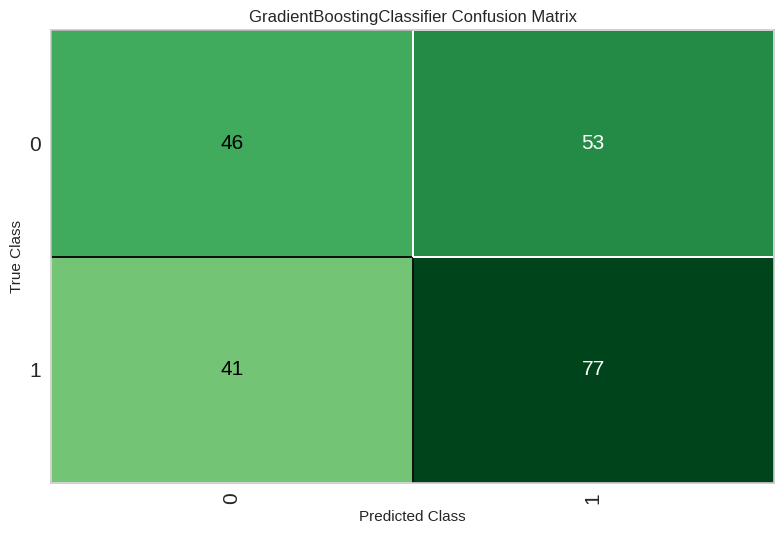

In [22]:
plot_model(best_model_tuned, plot="confusion_matrix")

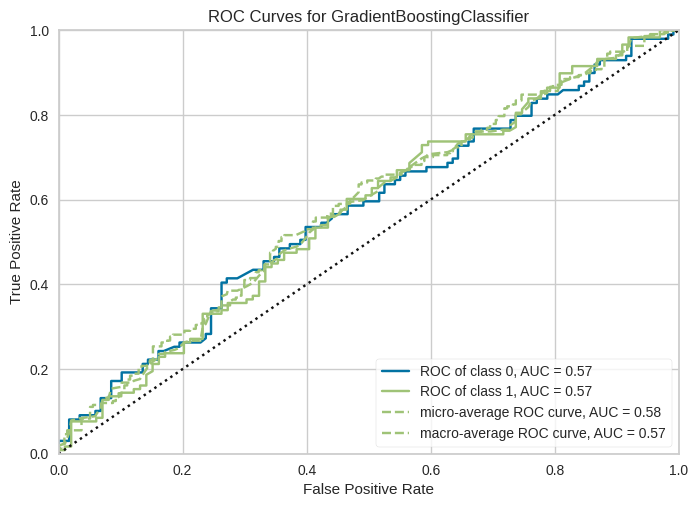

In [23]:
plot_model(best_model_tuned, plot="auc")

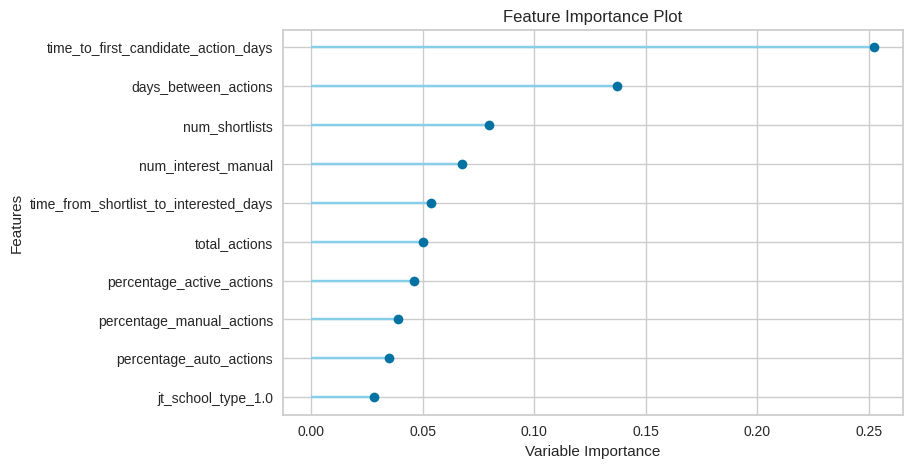

In [24]:
# Feature importance visualization
plot_model(best_model_tuned, plot = 'feature')

In [26]:
 # Model saving
save_model(best_model_tuned, 'best_model_tuned')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['total_actions',
                                              'days_between_actions',
                                              'percentage_active_actions',
                                              'percentage_manual_actions',
                                              'percentage_auto_actions',
                                              'num_shortlists',
                                              'n...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.05, loss='log_loss',
                                            

### **Conclusion:**

The classification model developed to predict candidate success in JobTeaser achieved an accuracy of **58%**, indicating room for improvement. This relatively low accuracy can likely be attributed to the quality and complexity of the data. One of the key challenges was the presence of multiple entries per user in the Candidate Status Update and Opt-in tables, representing various events. These records did not always follow a logical or consistent sequence, making it difficult to derive clear patterns for prediction. Consequently, while the model was tuned using cross-validation to identify the best possible configuration, the underlying data inconsistencies likely limited its overall performance.

Despite these challenges, the model provides valuable **insights into the variables that may most influence candidate success**, particularly regarding the time between actions, especially manual ones. This suggests that active participation in the process could significantly enhance the likelihood of success for candidates.

In future iterations, improving data quality by ensuring cleaner and more logically structured records could lead to higher model precision and better predictive power.